In [1]:
# Clear all variables in the workspace
%reset -f

In [2]:
import custom_system_properties as csp

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md

In [5]:
import oommfc as oc

## Main parameters

In [6]:
system = mm.System(name='dmi_test')

system_prop = csp.SystemProperties(lx=6152e-9, ly=4e-9, lz=4e-9)
system_prop.cell = (8e-9, 4e-9, 4e-9)
system_prop.units = ('m', 'm', 'm')
#system_prop.update_lengths()
system_prop.update_numcells()

In [7]:
system_prop

SystemProperties(lx=6.152e-06, ly=4e-09, lz=4e-09, cell=(8e-09, 4e-09, 4e-09), p1=(0, 0, 0), units=('m', 'm', 'm'), p2=(6.152e-06, 4e-09, 4e-09), numcells=(768, 1, 1))

In [8]:
# Saturisation magnetisation
Ms = 800e3  # kA/m

# exchange stiffness
A = 1.3e-11 # (43.5 * Ms * system_prop.cell[0])/2

# External static Zeeman field strength
H0 = tuple(x/mm.consts.mu0 for x in [0, 0, 0.4])  # A/m

# External dynamic Zeeman field strength
h0 = tuple(x/mm.consts.mu0 for x in [3e-3, 0, 0])  # A/m

# Driving frequency
f = 15.6e9  # Hz

# Stepsize at which equations are evaluated
h = 1e-15  # s

# Gilbert damping
alpha = 0.001

# DMI constant
D_ij = 0.4e-3  # J/m^2

gamma0 = 29.2e9 * (2 * np.pi * mm.consts.mu0) # [Hz / (rad T)] to correct units

## Regions

In [9]:
(((6152 - 2 * 8)- (25 * 8) - (38 * 8 * 2)) / 2) / 8

333.0

In [10]:
system_region = csp.MyRegions(system.name + "_regions");

system_region.main(p1=system_prop.p1, p2=system_prop.p2, 
                   dims=('x', 'y', 'z'), units=system_prop.units);

Created subregion: main


In [11]:
%%capture
system_subregions = csp.MyRegions(system.name + "_subregions")

system_subregions.fixedLhs(p1=system_region.main.p1, 
                           p2=(system_prop.cell[0], system_prop.ly, system_prop.lz), 
                           dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingLhs(p1=csp.add_tuples(system_subregions.fixedLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.fixedLhs.p2, system_prop.cell, 
                                       mult=38, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeLhs(p1=csp.add_tuples(system_subregions.dampingLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.dampingLhs.p2, system_prop.cell, 
                                       mult=333, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.driven(p1=csp.add_tuples(system_subregions.freeLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeLhs.p2, system_prop.cell, mult=25, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeRhs(p1=csp.add_tuples(system_subregions.driven.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.driven.p2, system_prop.cell, 
                                       mult=333, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingRhs(p1=csp.add_tuples(system_subregions.freeRhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeRhs .p2, system_prop.cell, 
                                       mult=38, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.fixedRhs(p1=csp.add_tuples(system_region.main.p2, system_prop.cell, 
                                         mult=-1, dims='x', base=system_prop.p1),
                           p2=system_region.main.p2, 
                           dims=('x', 'y', 'z'), units=system_prop.units)

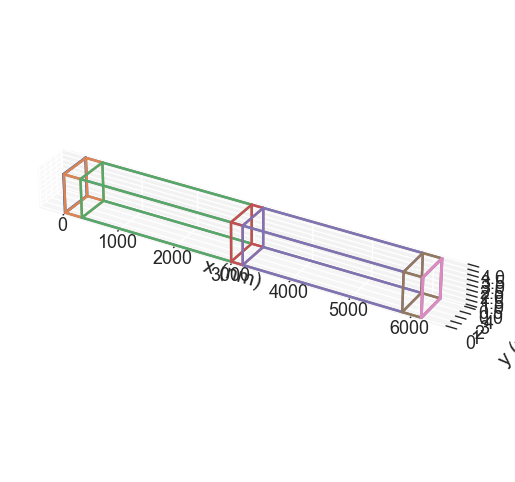

In [12]:
system_region._mesh = df.Mesh(region=system_region.main.region, 
                              cell=system_prop.cell,
                              subregions=system_subregions.regions)

system_region._mesh.mpl.subregions(figsize=(8, 6), multiplier=1e-9,box_aspect=(10, 1, 1), show_region=True)

### Energy equations

In [13]:
def h0_func(pos):
    if pos in system_subregions.driven.region:
        return h0
    else:
        return (0, 0, 0)
    #x, y, z = pos
    
    #if system_subregions.driven.p1[0] <= x < system_subregions.driven.p2[0]:
    #    return h0
    #else:
    #    return (0,0,0)

In [14]:
# system_subregions.driven.mesh = df.Mesh(region=system_region.main.region, cell=system_prop.cell)

In [15]:
h0_field = df.Field(mesh=system_region._mesh, nvdim=3, value=h0_func)
#region_values = {"region1": (1, 1, 1), "region2": (2, 2, 2)}
#h0_field.update_field_values(region_values)

In [16]:
system.energy = mm.Zeeman(H=H0, name='static') + mm.Exchange(A=A) + mm.DMI(D=D_ij, crystalclass='T')

In [17]:
system.energy

Zeeman(H=(0.0, 0.0, 318309.8861837907)) + Exchange(A=1.3e-11) + DMI(D=0.0004, crystalclass='T')

### dynamics

In [18]:
alpha_scaled = np.linspace(alpha, alpha * 100, system_prop.numcells[0]+1)
alpha_scaled_r = alpha_scaled[::-1]

In [19]:
def alpha_func(pos):
    if pos in system_subregions.dampingLhs.region:
        x_coord = int(pos[0] / system_prop.cell[0])
        return alpha_scaled_r[x_coord]
    elif pos in system_subregions.dampingRhs.region:
        x_coord = int(pos[0] / system_prop.cell[0])
        return alpha_scaled[x_coord]
    elif pos in system_subregions.freeLhs.region or pos in system_subregions.driven.region or pos in system_subregions.freeRhs.region:
        return alpha
    else:
        return alpha

In [20]:
alpha_field = df.Field(mesh=system_region._mesh, nvdim=1, value=alpha_func)

In [21]:
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha_field)

In [22]:
system.dynamics

Precession(gamma0=230553.9588094474) + Damping(alpha=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[6.152e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[769, 1, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[8e-09, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[8e-09, 0.0, 0.0], pmax=[3.1200000000000004e-07, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[3.1200000000000004e-07, 0.0, 0.0], pmax=[2.9760000000000004e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[2.9760000000000004e-06, 0.0, 0.0], pmax=[3.1760000000000006e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeRhs`(pmin=[3.1760000000000006e-06, 0.0, 0.0], pmax=[5.840000000000001e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingRhs`(pmin=[5.840000000000001e-06, 0.0, 0.0], pmax=[6.144000000000001e-06, 4e-09, 4e-09], dims=['x'

In [23]:
def m_init_func(pos):
    if pos in system_subregions.fixedLhs.region or pos in system_subregions.fixedRhs.region:
        return (0, 0, 1)
    else:
        return (0, 0, 1)

In [24]:
#system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=mag_vals, norm=Ms)
system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=(0, 0, 1), norm=Ms)

### Relaxation

In [25]:
minD = oc.MinDriver()
minD.drive(system, fixed_subregions=['fixedLhs', 'fixedRhs'], verbose=2)  # fixed_subregions=['fixedLhs', 'fixedRhs']

Running OOMMF (TclOOMMFRunner)[2024/06/03 15:45]... (1.0 s)


/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


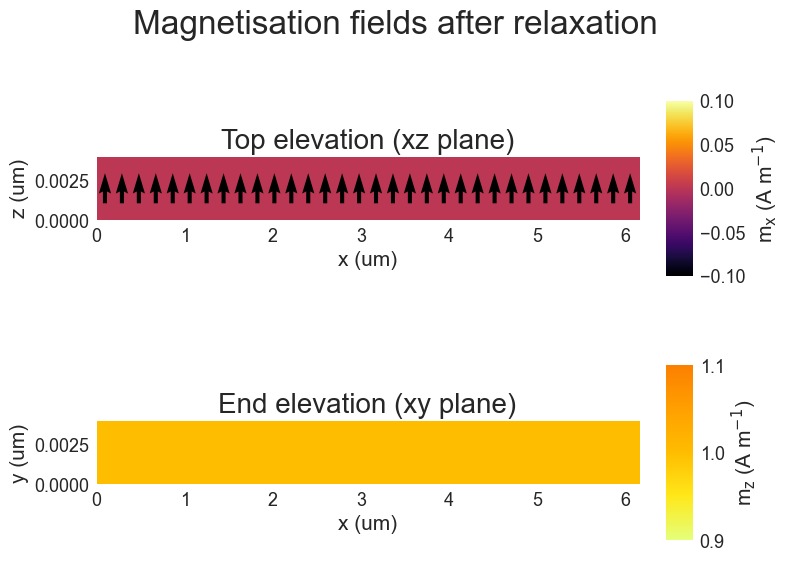

In [26]:
fig1, fig1_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig1.suptitle('Magnetisation fields after relaxation', fontsize=24)

system.m.orientation.sel('y').resample((128, 2)).x.mpl.scalar(ax=fig1_axs[0], cmap='inferno', colorbar_label='m$_\\text{x}$ (A m$^{-1}$)')
system.m.orientation.sel('y').resample((32, 1)).mpl.vector(ax=fig1_axs[0], 
                                               vdims=['x', 'z'],
                                               color_field=system.m.z.sel("y"),
                                               use_color=False,
                                               colorbar=False)
fig1_axs[0].set(title='Top elevation (xz plane)', aspect=180)

system.m.orientation.sel('z').resample((128, 2)).z.mpl.scalar(ax=fig1_axs[1], cmap='Wistia', colorbar_label='m$_\\text{z}$ (A m$^{-1}$)')
system.m.orientation.sel('z').resample((32, 1)).mpl.vector(ax=fig1_axs[1], 
                                               vdims=['x', 'y'],
                                               color='black',
                                               use_color=False)

fig1_axs[1].set(title='End elevation (xy plane)', aspect=180)


fig1.tight_layout()

In [27]:
#m = system.m.orientation

### Time-dependent field

In [28]:
system.energy += mm.Zeeman(H=h0_field, name='pump', func='sin',f=f, t0=0)

In [29]:
system.energy

Zeeman(H=(0.0, 0.0, 318309.8861837907)) + Exchange(A=1.3e-11) + DMI(D=0.0004, crystalclass='T') + Zeeman(H=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[6.152e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[769, 1, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[8e-09, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[8e-09, 0.0, 0.0], pmax=[3.1200000000000004e-07, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[3.1200000000000004e-07, 0.0, 0.0], pmax=[2.9760000000000004e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[2.9760000000000004e-06, 0.0, 0.0], pmax=[3.1760000000000006e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeRhs`(pmin=[3.1760000000000006e-06, 0.0, 0.0], pmax=[5.840000000000001e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingRhs`(pmin=[5.840000000000001e-06, 0.0, 0.0],

In [30]:
#oc.RungeKuttaEvolver._allowed_attributes

In [31]:
sim_evolver = oc.RungeKuttaEvolver(method='rk4',
                                   alpha=alpha,
                                   gamma_G=gamma0,
                                   min_timestep=0,
                                   max_timestep=h,
                                   fixed_spins=['main', 'fixedLhs', 'fixedRhs'],
                                   do_precess=1,
                                   allow_signed_gamma=0)

In [32]:
#oc.TimeDriver._allowed_attributes

In [33]:
td = oc.TimeDriver(name='stage1_timedriver')

In [34]:
td.drive(system, t=5e-9, n=1000, fixed_subregions=['fixedLhs', 'fixedRhs'], verbose=2)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/1000 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2024/06/03 15:45] took 7.4 s


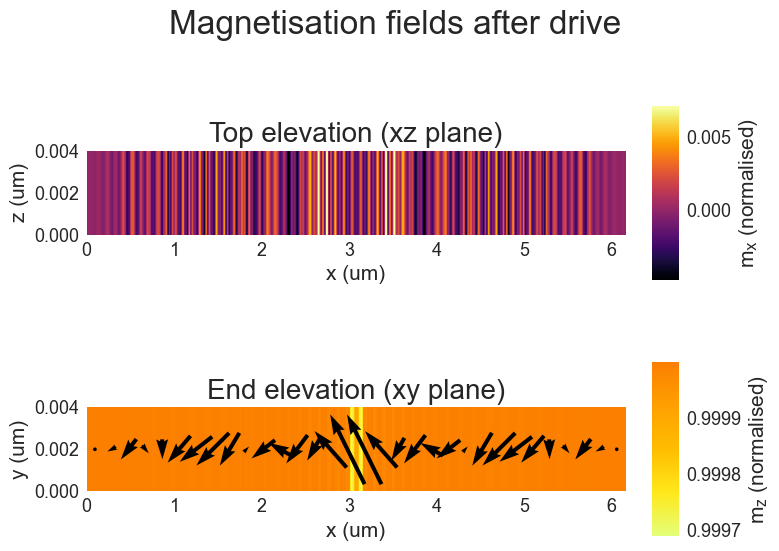

In [73]:
fig2, fig2_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig2.suptitle('Magnetisation fields after drive', fontsize=24)

system.m.orientation.sel('y').resample((512, 2)).x.mpl.scalar(ax=fig2_axs[0], cmap='inferno', colorbar_label='m$_\\text{x}$ (normalised)')
system.m.orientation.sel('y').resample((32, 1)).mpl.vector(ax=fig2_axs[0],
                                               #color_field=system.m.orientation.y.sel("y"),
                                               color='black', alpha=0,
                                               use_color=False,
                                               colorbar=False)
fig2_axs[0].set(title='Top elevation (xz plane)', aspect=240)

system.m.orientation.sel('z').resample((256, 2)).z.mpl.scalar(ax=fig2_axs[1], cmap='Wistia', colorbar_label='m$_\\text{z}$ (normalised)')
system.m.orientation.sel('z').resample((32, 1)).mpl.vector(ax=fig2_axs[1],
                                               color='black',
                                               use_color=False)

fig2_axs[1].set(title='End elevation (xy plane)', aspect=240)


fig2.tight_layout()

In [36]:
%matplotlib inline

In [90]:
my_data = md.Drive(name='dmi_test', number=3)

In [91]:
m_vals1 = np.empty((1000, 3))
m_vals2 = np.empty((1000, 3))

for i in range(0, my_data.n):
    m_vals1[i] = my_data[i].to_xarray()[160, 0, 0]
    m_vals2[i] = my_data[i].to_xarray()[600, 0, 0]

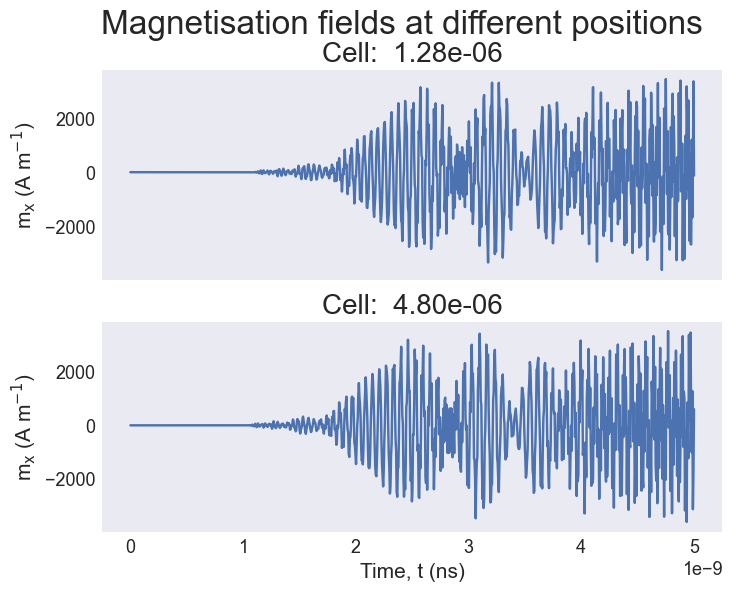

In [96]:
fig3, fig3_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
fig3.suptitle(f'Magnetisation fields at different positions', fontsize=24)

fig3_cell1 = 160
fig3_axs[0].plot(my_data.table.data['t'].to_numpy(),
         m_vals1[:, 0])
fig3_axs[0].set(title=f'Cell: {fig3_cell1 * system_prop.cell[0]: 2.2e}', ylabel='m$_\\text{x}$ (A m$^{-1}$)')

fig3_cell2 = 600
fig3_axs[1].plot(my_data.table.data['t'].to_numpy(),
         m_vals2[:, 0])
fig3_axs[1].set(title=f'Cell: {fig3_cell2 * system_prop.cell[0]: 2.2e}', 
                xlabel='Time, t (ns)', ylabel='m$_\\text{x}$ (A m$^{-1}$)')
plt.show()

In [48]:
def plt_mag(t_val):
    fig4, fig4_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    fig4.suptitle('Magnetisation fields after drive', fontsize=24)
    
    my_data[t_val].orientation.sel('y').resample((256, 2)).x.mpl.scalar(ax=fig4_axs[0], cmap='inferno', colorbar_label='m$_\\text{x}$ (normalised)')
    my_data[t_val].orientation.sel('y').resample((32, 1)).mpl.vector(ax=fig4_axs[0],
                                                   #color_field=system.m.orientation.y.sel("y"),
                                                   color='black', alpha=0,
                                                   use_color=False,
                                                   colorbar=False)
    fig4_axs[0].set(title='Top elevation (xz plane)', aspect=180)
    
    my_data[t_val].orientation.sel('z').resample((256, 2)).z.mpl.scalar(ax=fig4_axs[1], cmap='Wistia', colorbar_label='m$_\\text{z}$ (normalised)')
    my_data[t_val].orientation.sel('z').resample((32, 1)).mpl.vector(ax=fig4_axs[1],
                                                   color='black',
                                                   use_color=False)
    
    fig4_axs[1].set(title='End elevation (xy plane)', aspect=180)
    
    
    fig4.tight_layout()

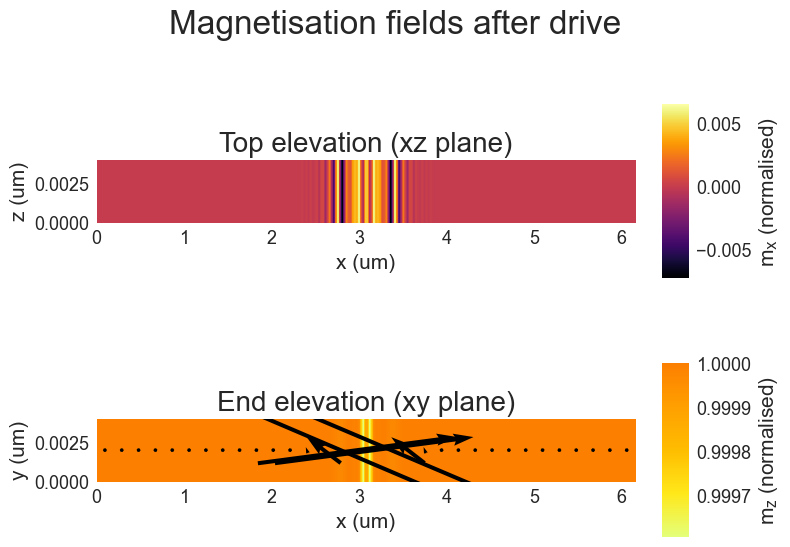

In [70]:
plt_mag(90)

In [ ]:
my_data.table.data['t'].to_numpy()

In [ ]:
plt.plot()

In [ ]:
#system.m

In [ ]:
system.table.data.plot('t', 'mx', xlabel='time, t (ns)', ylabel='avg. m$_\\text{x}$ (A m$^{-1}$)')

In [ ]:
position = (1024e-9, 0, 0)

In [ ]:
system.m.orientation((position[0], position[1], position[2]))

In [ ]:
import os

In [ ]:
# Define the directory containing your .omf files
omf_dir = '/Users/cameronmceleney/PycharmProjects/Ubermag/include/breaking_test/drive-14'

# List all .omf files in the directory
omf_files = sorted([f for f in os.listdir(omf_dir) if f.endswith('.omf') and f != 'm0.omf'])

In [ ]:
times = system.table.data['t']

In [ ]:
# Initialize lists to store magnetization components
times = []
mx_values = []
my_values = []
mz_values = []

# Read each .omf file and extract the magnetization at the specified position
for omf_file in omf_files:
    # Read the field from the .omf file
    field = df.Field.from_file(os.path.join(omf_dir, omf_file))
    exit(0)
    
    # Extract the magnetization components at the specified position
    m_at_pos = field(position)
    mx_values.append(m_at_pos[0])
    my_values.append(m_at_pos[1])
    mz_values.append(m_at_pos[2])
    
    # Extract the time from the filename (assuming filenames have time information)
    # Example: "filename_t=0.omf" -> time = 0
    time = float(omf_file.split('t=')[1].split('.omf')[0])
    times.append(time)

In [ ]:
plt.plot(times, mx_values)

In [ ]:
# Plot the magnetization components over time
plt.figure(figsize=(8, 6))
plt.plot(times, mx_values, label='m$_\\text{x}$ (normalized)')
plt.plot(times, my_values, label='m$_\\text{y}$ (normalized)')
#plt.plot(times, mz_values, label='m$_\\text{z}$ (normalized)')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization (normalized)')
plt.title('Magnetization components at position {} over time'.format(position))
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig2, (fig2_ax1, fig2_ax2, fig2_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
fig2.suptitle('Magnetisation fields after relaxation (y-plane)', fontsize=24)

# plot vectors on grid of 20 x 5 over the numerical resulotion
system.m.x.sel("y").mpl(ax=fig2_ax1, scalar_kw={"colorbar_label": "m$_\\text{x}$ (A m$^{-1}$)"})
fig2_ax1.set(aspect=200)

system.m.y.sel('y').mpl(ax=fig2_ax2, scalar_kw={"colorbar_label": "m$_\\text{y}$ (A m$^{-1}$)"})
fig2_ax2.set(aspect=200)

system.m.z.sel('y').mpl(ax=fig2_ax3, scalar_kw={"colorbar_label": "m$_\\text{z}$ (A m$^{-1}$)"})
fig2_ax3.set(aspect=200)

In [ ]:
data = md.Data(system.name)

In [ ]:
data.info

In [ ]:
# Use only the last time drive
time_drive = data[1]
time_drive.info
print(time_drive.calculator_script)

In [ ]:
#list(time_drive)
#time_drive.to_xarray()

In [ ]:
fig3, fig3_axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
time_drive[700].sel('y').mpl(ax=fig3_axs, vector_kw={'color':'white', 'alpha':0})
fig3_axs.set(aspect=60)

In [ ]:
data_oi = []

In [ ]:
for i in range(0, 4000):
    data_oi.append(time_drive[])

In [ ]:

time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-Ms, Ms), "cmap": "coolwarm"},
)